## proof of concept for EMT decision-support

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [331]:
# define parameters
waitPerEDPatient = 2.0 # about an hour
waitPerAmbulance = 1.0 # 20 minutes

In [337]:
class Patient:
    def __init__(self,location,health):
        self.health = health
        self.location = location
        self.status = 0
        self.hospital = None
        self.waitTime = 0
        self.waitForED = 0 
        self.waitForICU = 0 
    def updateLocation(self,hospital):
        self.hospital = hospital
    def updateWaitTime(self,time):
        self.waitTime += time
    def setEDTime(self):
        self.waitForED = self.waitTime
    def setICUTime(self):
        self.waitForICU = self.waitTime

class ICU:
    def __init__(self,name,metadata): # passed ICU metadata
        self.name = name
        self.max_beds = metadata['max_beds']
        self.max_ventilators = metadata['max_ventilators']
        self.used_beds = 0
        self.used_ventilators = 0
        self.patients = []
    def updateUsed(self,delta_beds=1, delta_ventilators=1,patient=None):
        self.used_beds += delta_beds
        self.used_ventilators += delta_ventilators
        if (patient != None and delta_beds > 0):
            self.patients.append(patient)
            patient.setICUTime()
        elif (patient != None and delta_beds < 0):
            self.patients.remove(patient)
            
    
class ED:
    def __init__(self,name,metadata): # passed ER metadata
        self.name = name
        self.max_beds = metadata['max_beds']
        self.used_beds = 0
        self.patients = []
    def updateUsed(self,delta_beds=1,patient=None):
        self.used_beds += delta_beds
        if (patient != None and delta_beds > 0):
            self.patients.append(patient)
            patient.setEDTime()
        elif (patient != None and delta_beds < 0):
            self.patients.remove(patient)
        
class Hospital:
    def __init__(self,name,metadata): # passed hospital metadata
        self.name = name 
        self.location = metadata['location']
        self.ICU = ICU(name=self.name,metadata=metadata['ICU'])
        self.ED = ED(name=self.name,metadata=metadata['ED'])
        self.patients = []
    def distanceToPatient(self,location):
        return np.linalg.norm(self.location-location)
    def availableBedED(self):
        return self.ED.max_beds-self.ED.used_beds
    def availableBedICU(self):
        return self.ICU.max_beds-self.ICU.used_beds
    def availableVentilatorICU(self):
        return self.ICU.max_ventilators-self.ICU.used_ventilators
    def admitToED(self,delta_beds=1,patient=None):
        self.ED.updateUsed(delta_beds=delta_beds,patient=patient)
        if (patient != None):
            self.patients.remove(patient)
    def admitToICU(self,delta_beds=1,delta_ventilators=1,patient=None):
        self.ED.updateUsed(delta_beds=-delta_beds,patient=patient)
        self.ICU.updateUsed(delta_beds=delta_beds,delta_ventilators=delta_ventilators,patient=patient)
    def dischargeFromED(self,delta_beds=1,patient=None):
        self.ED.updateUsed(delta_beds=-delta_beds,patient=patient)
    def dischargeFromICU(self,delta_beds=1,delta_ventilators=1,patient=None):
        self.ICU.updateUsed(delta_beds=-delta_beds,delta_ventilators=-delta_ventilators,patient=patient)
        
    def scanAdmit(self):
        args = np.argsort([p.health for p in self.patients])
        ordered_patients = [self.patients[i] for i in args]
        for i,p in enumerate(ordered_patients):
            if self.availableBedED()>0:
                self.admitToED(patient=p)
                if (p.health<=0.25 and self.availableBedICU()>0):
                    self.admitToICU(patient=p)
            else: break
                
    def updateHospital(self,patient=None,alpha=50):
        if (patient != None):
            self.patients.append(patient)
            patient.updateLocation(self)
            patient.updateWaitTime(waitPerAmbulance*self.distanceToPatient(patient.location))
        self.scanAdmit()
        for tempPatient in self.patients:
            tempPatient.updateWaitTime(waitPerEDPatient)
        for p in self.ED.patients:
            if p.health>alpha*np.random.random() and p.health>0.25: self.dischargeFromED(patient=p)
        for p in self.ICU.patients:
            if p.health>alpha*np.random.random()/2: self.dischargeFromICU(patient=p)

    
class City:
    def __init__(self,metadata): # all metadata
        self.hospitals = []
        for name in metadata.keys():
            self.hospitals.append(Hospital(name=name,metadata=metadata[name]))
    def availableBedED(self):
        avgBedUse = 0
        for hospital in self.hospitals:
            avgBedUse =+ hospital.ED.max_beds-hospital.ED.used_beds
        return self.ED.max_beds-self.ED.used_beds
    # naive implemtnation
    def new_patient_naive(self,patient):
        distances = []
        for hospital in self.hospitals:
            distances += [hospital.distanceToPatient(patient.location)]
        h = self.hospitals[np.argsort(distances)[0]]
        h.updateHospital(patient=patient)
        # update all other hospitals
        for hospital in self.hospitals:
            if h != hospital:
                hospital.updateHospital(patient=None)
    # communication implementation
    def new_patient(self,patient,alpha=1.0,beta=5.0):
        metric = []
        distances = []
        for hospital in self.hospitals:
            distances += [hospital.distanceToPatient(patient.location)]
            # define metric
            metric += [(alpha*(hospital.availableBedED()))+
                       (beta*((1-patient.health)*(hospital.availableVentilatorICU())))] 
        h = self.hospitals[np.argsort(metric)[-1]]
        h.updateHospital(patient=patient)
        # update all other hospitals
        for hospital in self.hospitals:
            if h != hospital:
                hospital.updateHospital(patient=None)
                    
    def get_untreated(self):
        sum_ = 0
        for h in self.hospitals:
            sum_ += len(h.patients)
        return sum_

In [338]:
def createPatient():
    location = np.asarray([np.random.random(),np.random.random()])
    health = np.random.randint(5,995)/1000
    patient = Patient(location=location,health=health)
    return patient

def simulate(city1,city2,nH,nP,nT=1): 
    ed = np.zeros(nP*nH).reshape([nH,nP]) # ED bed availability over "time"
    wt = np.zeros(nP) # wait time for individual patients for ED
    vt = np.zeros(nP) # wait time for individual patients for ICU
    ht = np.zeros(nP) # health of each patient 
    ut = np.zeros(nP) # health of each patient 
    ed2 = np.zeros(nP*nH).reshape([nH,nP])
    wt2 = np.zeros(nP) 
    vt2 = np.zeros(nP) 
    ht2 = np.zeros(nP) 
    ut2 = np.zeros(nP)
    for trial in range(nT):
        inpatient1 = []
        inpatient2 = []
        for i in range(nP): 
            patient = createPatient()
            inpatient1.append(patient)
            city1.new_patient(patient)
            for hospital in city1.hospitals:
                j = hospital.name[0]*int(np.sqrt(nH))+hospital.name[1]
                ed[j,i] += hospital.availableBedED()/nT
            ht[i] += patient.health/nT
            ut[i] += city1.get_untreated()/nT
            # second model below
            patient = createPatient()
            inpatient2.append(patient)
            city2.new_patient_naive(patient)
            for hospital in city2.hospitals:
                j = hospital.name[0]*int(np.sqrt(nH))+hospital.name[1]
                ed2[j,i] += hospital.availableBedED()/nT
            ht2[i] += patient.health/nT
            ut2[i] += city2.get_untreated()/nT
        for i,patient in enumerate(inpatient1):
            wt[i] += patient.waitForED/nT
            vt[i] += patient.waitForICU/nT
        for i,patient in enumerate(inpatient2):
            wt2[i] += patient.waitForED/nT
            vt2[i] += patient.waitForICU/nT
    return ed,wt,vt,ht,ut,ed2,wt2,vt2,ht2,ut2

199760.0 177848.0


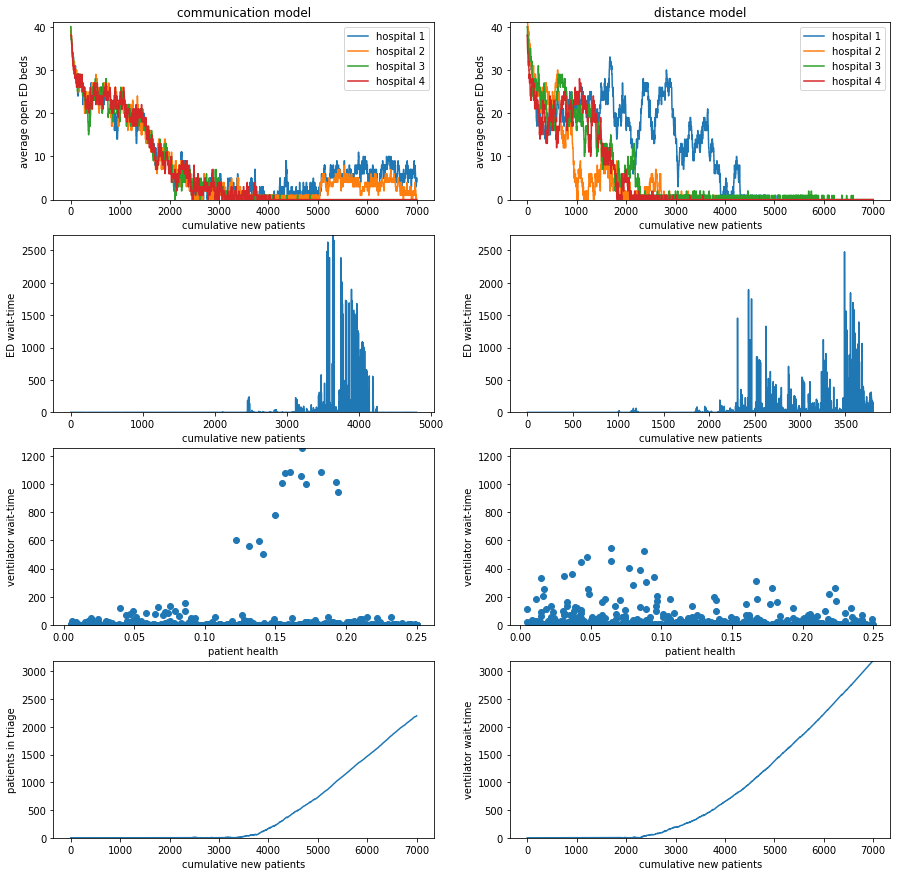

In [339]:
fig = plt.figure(figsize=(15,15))

nH = 4 # hospitals
nP = 7000 # patients

metadata = {}
# create hospitals
for i in range(int(np.sqrt(nH))):
    for j in range(int(np.sqrt(nH))):
        name = (i,j)
        maxBed = np.random.randint(20,50)
        metadata[name] = {'location': (np.linspace(0,1,int(np.sqrt(nH)))[i],
                                       np.linspace(0,1,int(np.sqrt(nH)))[j]), 
                          'ED': {'max_beds': maxBed}, 
                          'ICU': {'max_beds':int(0.50*maxBed), 
                          'max_ventilators': int(0.50*maxBed)} }

city1 = City(metadata=metadata) # our model
city2 = City(metadata=metadata) # naive model
ed1,wt1,vt1,ht1,ut1,ed2,wt2,vt2,ht2,ut2 = simulate(city1,city2,nH,nP,nT=1)

print(np.sum(ed1),np.sum(ed2))

ax = fig.add_subplot(421)
for i in range(nH):
    ax.plot(ed1[i],label='hospital '+str(i+1))
ax.legend()
ax.set_ylabel('average open ED beds')
ax.set_xlabel('cumulative new patients')
ax.set_title('communication model')
ax.set_ylim([np.min([ed1,ed2]),np.max([ed1,ed2])])

ax = fig.add_subplot(422)
for i in range(nH):
    ax.plot(ed2[i],label='hospital '+str(i+1))
ax.legend()
ax.set_ylabel('average open ED beds')
ax.set_xlabel('cumulative new patients')
ax.set_title('distance model')
ax.set_ylim([np.min([ed1,ed2]),np.max([ed1,ed2])])

ax = fig.add_subplot(423)
relInds = wt1 >0
ax.plot(wt1[relInds])
#ax.plot(np.cumsum(wt1[relInds])/np.linspace(1,len(relInds),len(relInds)))
ax.set_ylabel('ED wait-time')
ax.set_xlabel('cumulative new patients')
ax.set_ylim([np.min([wt1,wt2]),np.max([wt1,wt2])])

ax = fig.add_subplot(424)
relInds = wt2 >0
ax.plot(wt2[relInds])
#ax.plot(np.cumsum(wt2[relInds])/np.linspace(1,len(relInds),len(relInds)))
ax.set_ylabel('ED wait-time')
ax.set_xlabel('cumulative new patients')
ax.set_ylim([np.min([wt1,wt2]),np.max([wt1,wt2])])

ax = fig.add_subplot(425)
relInds = vt1 >0
ax.plot(ht1[relInds],vt1[relInds],'o')
#ax.plot(np.cumsum(vt1)/np.linspace(1,nP,nP))
ax.set_ylabel('ventilator wait-time')
ax.set_xlabel('patient health')
ax.set_ylim([np.min([vt1,vt2]),np.max([vt1,vt2])])

ax = fig.add_subplot(426)
relInds = vt2>0 
ax.plot(ht2[relInds],vt2[relInds],'o')
#ax.plot(np.cumsum(vt2)/np.linspace(1,nP,nP))
ax.set_ylabel('ventilator wait-time')
ax.set_xlabel('patient health')
ax.set_ylim([np.min([vt1,vt2]),np.max([vt1,vt2])])

ax = fig.add_subplot(427)
ax.plot(ut1)
ax.set_ylabel('patients in triage')
ax.set_xlabel('cumulative new patients')
ax.set_ylim([np.min([ut1,ut2]),np.max([ut1,ut2])])

ax = fig.add_subplot(428)
ax.plot(ut2)
ax.set_ylabel('ventilator wait-time')
ax.set_xlabel('cumulative new patients')
ax.set_ylim([np.min([ut1,ut2]),np.max([ut1,ut2])])

pass

below code is attempt at kinetic monte carlo

In [111]:
def getPropensity(k,intermediates,patients,ed_patients,icu_patients):
    kcall, kambu, ktravel, kadmit, kEDdis, kICUdis = k
    prePatient, ambulance, dispatch, triage = intermediates
    prop = np.asarray([kcall,
                       kambu*prePatient*ambulance,
                       ktravel*dispatch,
                       kadmit*triage*len(patients),
                       kICUdis*len(icu_patients),
                       kEDdis*len(ed_patients)])
    return prop


def simulate(city,nH,model=None,Tt=24.0,nT=1): 
    nP = 50000
    ed = np.zeros(nP*nH).reshape([nH,nP]) # ED bed availability over time
    #wt = np.zeros(nP) # city average wait-time until ED bed for all patients
    #vt = np.zeros(nP) # city average wait-time until ventilation for critical patients
    #ed2 = np.zeros(nP*nH).reshape([nH,nP])
    #wt2 = np.zeros(nP)
    #pt2 = np.zeros(nP)
    t = np.zeros(nP)
    kcall = 1e3 # ambulance calls per hour in nyc
    kambu = 1.0/(0.25) # average 15 minute response time
    ktravel = 1.0/(0.33) # average 20 minute ride, weighted by distance actually travelled
    kadmit = nH*1.0 # one hour average ED stay
    kICUdis = nH*1.0/(3*24.0) # on average, a bed clears up every 3 days
    kEDdis = nH*1.0/2.0 # one hour average ED stay
    k = np.asarray([kcall, kambu, ktravel, kadmit, kEDdis, kICUdis])
    #intermediates = np.zeros(4*nP).reshape([4,nP]) # prePatient, ambulance, dispatch, triage
    for trial in range(nT):
        tt = 0
        i = 0
        intermediates = np.asarray([0, 450, 0, 0]) # prePatient, ambulance, dispatch, triage
        patients = []
        ed_patients = []
        icu_patients = []
        for j in range(len(city.hospitals)):
                ed[j,i] = city.hospitals[j].availableBedED()/nT
        while (tt < Tt) and i < nP:
            prop = getPropensity(k,intermediates,patients,ed_patients,icu_patients)
            prop0 = np.sum(prop)
            dt = np.random.exponential(1/prop0,1)
            prop = np.cumsum(prop)/prop0
            rand = np.random.random()
            if (rand < prop[0]): # 911 is called
                intermediates[0] += 1 # increase prePatient
            elif (rand <prop[1]): # ambulance reaches callers
                patient = createPatient()
                if model=='naive':
                    hospital = city.new_patient_naive(patient)
                else:
                    hospital = city.new_patient(patient)
                patient.updateLocation(hospital)
                patients.append(patient)
                intermediates[0:2] -= 1 # decrease prePatient,ambulance
                intermediates[2] += 1 # increase dispatch
            elif (rand <prop[2]): # ambulance travels to hospital
                intermediates[2] -= 1 # decrease dispatch
                intermediates[3] += 1 # increase triage
            elif (rand <prop[3]): # patient gets admit to ED/ICU
                intermediates[3] -= 1 # decrease triage
                intermediates[1] += 1 # increase ambulance
                patient = patients.pop(0)
                if (patient.health<=0.25 and patient.hospital.availableBedICU()>0):
                    patient.hospital.admitToICU(patient=patient)
                    icu_patients.append(patient)
                elif (patient.hospital.availableBedED()>0):
                    patient.hospital.admitToED(patient=patient)
                    ed_patients.append(patient)
            elif (rand < prop[4]): # patient leaves ICU
                patient = icu_patients.pop(0)
                patient.hospital.dischargefromICU(patient=patient)
            else: # patient leave ED
                patient = ed_patients.pop(0)
                patient.hospital.dischargefromED(patient=patient)
            # update stats
            for j in range(len(city.hospitals)):
                ed[j,i] = city.hospitals[j].availableBedED()/nT
            #wt[i] += hos.distanceToPatient(patient.location)*(60*nP/k)/nT
            #vt[i] += np.mean(health_stats)/hos.availableVentilatorICU()/nT
            tt = tt + dt
            t[i] += tt/nT
            i += 1
            #print(intermediates)
    return t,ed

In [ ]:
if dwt[-1]>0:
    end = len(dwt)
else:
    end = np.where(dwt==0)[0][0]
print('average fail, communication model: ' + str(end))
if dwtN[-1]>0:
    endN = len(dwtN)
else:
    endN = np.where(dwtN==0)[0][0]
print('average fail, distance model: ' + str(endN))

print('total patient care, communication model: ' + str(np.round(np.sum(edwt))))
print('total patient care, distance model: ' + str(np.round(np.sum(edwtN))))

ax = fig.add_subplot(321)
for i in range(nH):
    ax.plot(t,edwt[i],label='hospital '+str(i+1))

ax.legend()
ax.set_ylabel('average open ED beds')
ax.set_xlabel('time (hours)')
ax.set_title('communication model')
#ax.set_ylim([np.min([edwtN,edwt]),2])#np.max([edwtN,edwt])])

ax = fig.add_subplot(322)
for i in range(nH):
    ax.plot(t,edwtN[i],label='hospital '+str(i+1))

ax.legend()
ax.set_ylabel('average open ED beds')
ax.set_xlabel('time (hours)')
ax.set_title('distance model')
#ax.set_ylim([np.min([edwtN,edwt]),2])#np.max([edwtN,edwt])])

ax = fig.add_subplot(323)
ax.plot(t,dwt)
ax.plot(t[0:end],np.cumsum(dwt[0:end])/np.linspace(1,end,end))
ax.set_ylabel('average relative wait-time (minutes)')
ax.set_xlabel('time (hours)')
#ax.set_ylim([np.min([dwtN,dwt]),60])#np.max([dwtN,dwt])])

ax = fig.add_subplot(324)
ax.plot(t,dwtN)
ax.plot(t[0:endN],np.cumsum(dwtN[0:endN])/np.linspace(1,endN,endN))
ax.set_ylabel('average relative wait-time (minutes)')
ax.set_xlabel('time (hours)')
#ax.set_ylim([np.min([dwtN,dwt]),60])#np.max([dwtN,dwt])])
